In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
from pathlib import Path
import itertools
import pickle
import seaborn as sns
import jax
import jax.numpy as np
import numpy
import scipy
import seaborn as sns
from tqdm import tqdm
jax.config.update('jax_platform_name', 'cpu')
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=16'

In [3]:
from sklearn.cluster import MiniBatchKMeans

In [94]:
from bomtemplate.bd_transformation import fc_phases_space, fc_space, activity_space
from bomtemplate.into_states import clustering
from bomtemplate.reliability_assessment import fingerprinting, predictive_power
from bomtemplate import utility
from bomtemplate import bd_preprocessing

In [5]:
cwd = os.getcwd()
head = Path(cwd).parents[1]
path_data = os.path.join(head, 'saved_data/')

In [6]:
getdata = bd_preprocessing.Get_1000Brains_Data(path_data)
output_dict = getdata.get_data(bins=False)
output_dict.keys()

dict_keys(['data_3d', 'ages', 'TR', 'transient'])

In [7]:
transient = output_dict['transient']
data_3d = output_dict['data_3d'][:,transient:]
n_participants, n_samples, n_nodes = data_3d.shape

In [8]:
lowcut = 0.01
highcut = 0.08
data_3d_filtered = numpy.zeros_like(data_3d)
for p in range(n_participants):
    data_3d_filtered[p] = bd_preprocessing.butter_bandpass_filter(data_3d[p], axis=0, lowcut=lowcut, highcut=highcut, fs=1, order=1)

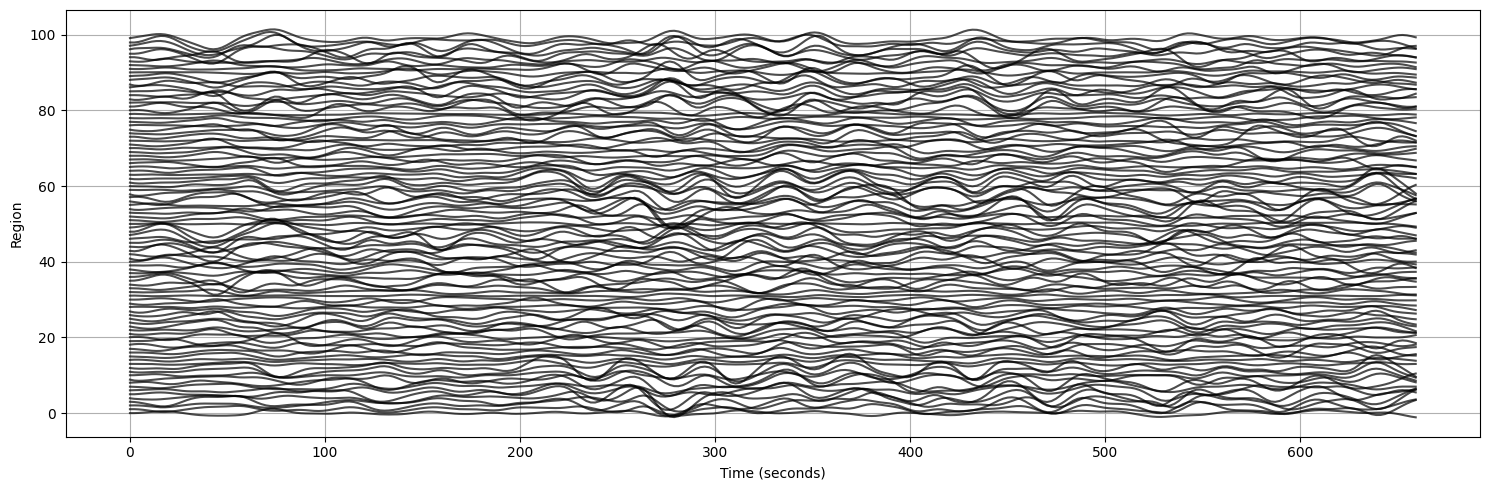

In [9]:
TR = output_dict['TR']
bd_preprocessing.plot_filtered_ts(data_3d_filtered[9], TR=TR)

## Leida Cen SC

## step 1: transform the data

In [10]:
est_v1s = fc_phases_space.V1s()
v1s = est_v1s.fit_transform(data_3d_filtered) #slow and memory expensive

## step2: cluster into recurrent objects

In [16]:
part = getdata.split_test_retest()
xtest = v1s[:,:part,:]
xretest = v1s[:,-part:,:]

In [30]:
counter

67

In [55]:
# wait for optimal number of states to be 8 (a bit stupid i guess)
n_states=None; n_states_all = []
new_evecs = 1
counter = 0
while n_states != 8:
    est = clustering.LeidaCenSC(n_states=None, n_init_clusters=50)
    est.fit(xtest)
    k_evecs = est.transform(xtest)
    if numpy.allclose(k_evecs, new_evecs):
        print('break')
        break
    new_evecs = k_evecs
    n_states = est.n_states
    n_states_all.append(n_states)
    counter += 1
    if counter > 50:
        break

In [58]:
telab = est.predict(k_evecs)
retelab = est.predict_on_unseen(xretest)

### fingerprinting

In [61]:
X = telab.reshape(n_participants, -1)
y = retelab.reshape(n_participants, -1)

In [63]:
fp = fingerprinting.Fingerprinting()
fp.fit(X, y)

Fingerprinting()

In [66]:
teor, reteor = fp.transform_to_occurence_ratio(X, y)

In [67]:
permst, obsst, pv = fp.score_intrasim_vs_intrasim(num_permutations=1000)

100%|██████████| 1000/1000 [00:00<00:00, 1684.06it/s]


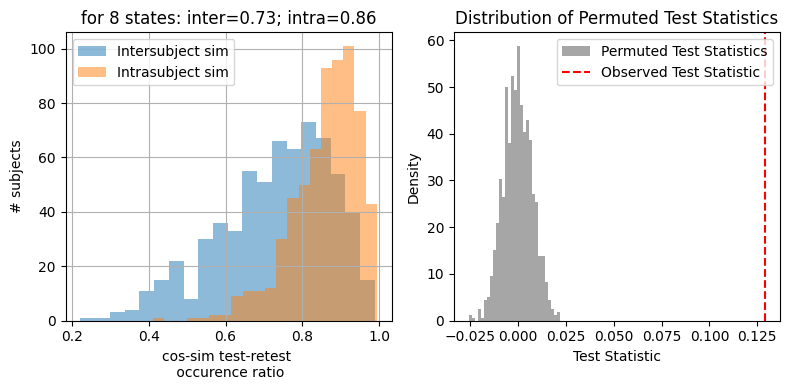

In [68]:
figure(figsize=(8,4))
subplot(121)
hist(fp.intersim, 20, label='Intersubject sim', alpha=0.5)
hist(fp.intrasim, 20, label='Intrasubject sim', alpha=0.5)
xlabel('cos-sim test-retest \n occurence ratio'); plt.ylabel('# subjects'); plt.grid(1);
title(f'for {fp.n_states} states: inter={fp.intersim.mean():0.2f}; intra={fp.intrasim.mean():0.2f}')
legend()
subplot(122)
hist(permst, bins=30, density=True, alpha=0.7, color='grey', label='Permuted Test Statistics')
axvline(x=obsst, color='red', linestyle='--', label='Observed Test Statistic')
xlabel('Test Statistic')
ylabel('Density')
title('Distribution of Permuted Test Statistics')
legend()
tight_layout()
show()

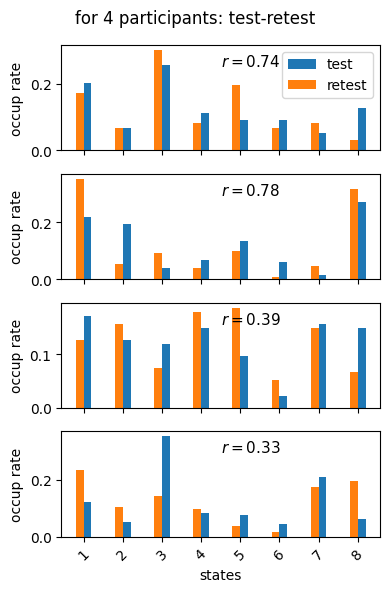

In [69]:
vor_corcoefs = np.zeros((n_participants))
for p in range(n_participants):
    vor_corcoefs = vor_corcoefs.at[p].set(np.corrcoef(fp.X_[p,:], fp.y_[p,:])[0,1])
x = np.arange(fp.n_states)
width=0.2
f, ax = plt.subplots(4,1,#4 subjects
                     sharex='col', sharey='row', figsize=(4,6))
for p in range(4): 
    ax[p].bar(x+width/2, fp.X_[p,:], width=width, label='test')
    ax[p].bar(x-width/2, fp.y_[p,:], width=width, label='retest')
    ax[p].set_xticks(x,x+1, rotation=45)
    ax[p].annotate(rf'$r={vor_corcoefs[p].round(3):0.02f}$', xy=(0.5, 0.8), xycoords='axes fraction', fontsize=11)
    ax[-1].set_xlabel('states')
    ax[p].set_ylabel('occup rate')
ax[0].legend()
f.suptitle('for 4 participants: test-retest')
plt.tight_layout();

### predictive power

In [71]:
train_idx, test_idx = getdata.split_train_test()

In [72]:
xtrain = v1s[train_idx].copy()
xtest = v1s[test_idx].copy()

In [87]:
xtrain.shape, xtest.shape

((516, 294, 100), (132, 294, 100))

In [88]:
# wait for optimal number of states to be 8 (a bit stupid i guess)
n_states=None; n_states_all = []
new_evecs = 1
counter = 0
while n_states != 8:
    est = clustering.LeidaCenSC(n_states=None, n_init_clusters=50)
    est.fit(xtrain)
    k_evecs = est.transform(xtrain)
    if numpy.allclose(k_evecs, new_evecs):
        print('break')
        break
    new_evecs = k_evecs
    n_states = est.n_states
    n_states_all.append(n_states)
    counter += 1
    if counter > 50:
        break

In [90]:
n_states, np.unique(np.array(n_states_all), return_counts=1)

(8,
 (Array([ 2,  3,  4,  5,  6,  8, 10], dtype=int32),
  Array([4, 9, 2, 9, 1, 1, 1], dtype=int32)))

In [111]:
trlab = est.predict(k_evecs)
telab = est.predict_on_unseen(xtest)

In [112]:
X = trlab.reshape(train_idx.size, -1)
test_array = telab.reshape(test_idx.size, -1)
ages = output_dict["ages"]
pp = predictive_power.Predict()
y = ages[train_idx]
pp.fit(X, y)

Predict()

In [113]:
predictors, r_values, p_values = pp.predict(test_array, ages[test_idx])
r_values, p_values

(0.11816112494407106, 0.17721231109434382)

(Text(0, 0.5, 'true age'), Text(0.5, 0, 'predicted age'))

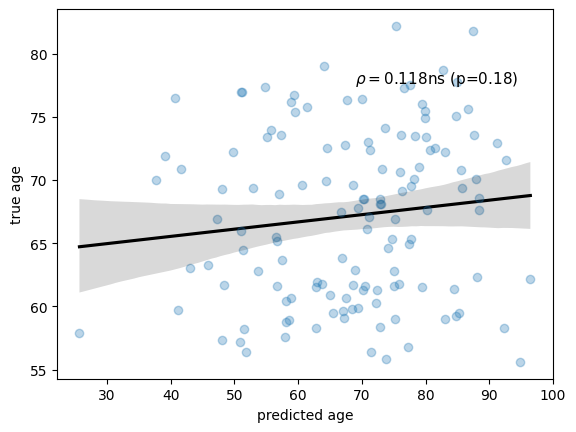

In [114]:
y = predictors
sns.regplot(x=y, y=ages[test_idx],
            line_kws=dict(color="k",zorder=0), ci=95, scatter_kws={"alpha": 0.3})
slope,_,r_value,p_value,_ = scipy.stats.linregress(x=y, y=ages[test_idx])
annotate(rf'$\rho={r_value.round(3)}${utility.convert_pvalue_to_asterisks(p_value)} (p={p_value:0.02f})',
         xy=(0.6, 0.8), xycoords='axes fraction', fontsize=11)
ylabel('true age'), xlabel('predicted age')